# Experiment 4 – Implement K-Nearest Neighbors (KNN) and Evaluate Model Performance

**Objective:** Implement the KNN classification algorithm on the **Iris** dataset and evaluate its performance using various metrics.

**Dataset:** `Iris.csv` — 150 samples, 4 numeric features, 3 species classes  
- **Iris-setosa**, **Iris-versicolor**, **Iris-virginica**  
- Features: SepalLengthCm, SepalWidthCm, PetalLengthCm, PetalWidthCm

**How KNN works:**  
For a new data point, KNN finds the **K closest** training samples (neighbours) and assigns the class that appears most among them (majority vote).

## Step 1 — Import Libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: preprocessing, model, and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

# Make plots look clean
sns.set_style("whitegrid")
print("All libraries imported successfully ✅")

All libraries imported successfully ✅


## Step 2 — Load and Explore the Dataset

In [2]:
# Load the CSV file into a DataFrame
df = pd.read_csv("Iris.csv")

# Display the first 5 rows to get an overview
print(f"Dataset shape: {df.shape[0]} rows × {df.shape[1]} columns\n")
df.head()

Dataset shape: 150 rows × 6 columns



,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
# Check data types and look for missing values
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    str    
dtypes: float64(4), int64(1), str(1)
memory usage: 7.2 KB


In [4]:
# Summary statistics for the numeric columns
df.describe()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,75.500000,5.843333,3.054000,3.758667,1.198667
std,43.445368,0.828066,0.433594,1.764420,0.763161
min,1.000000,4.300000,2.000000,1.000000,0.100000
25%,38.250000,5.100000,2.800000,1.600000,0.300000
50%,75.500000,5.800000,3.000000,4.350000,1.300000
75%,112.750000,6.400000,3.300000,5.100000,1.800000
max,150.000000,7.900000,4.400000,6.900000,2.500000


In [5]:
# Check for missing values and duplicates
print("Missing values per column:")
print(df.isnull().sum())
print(f"\nTotal missing values: {df.isnull().sum().sum()}")
print(f"Duplicate rows      : {df.duplicated().sum()}")

Missing values per column:
Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

Total missing values: 0
Duplicate rows      : 0


In [6]:
# How many samples per species?
print("Class distribution:")
print(df["Species"].value_counts())

Class distribution:
Species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64


## Step 3 — Visualise the Data

/tmp/ipykernel_17925/741431036.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Species", data=df, palette="Set2")


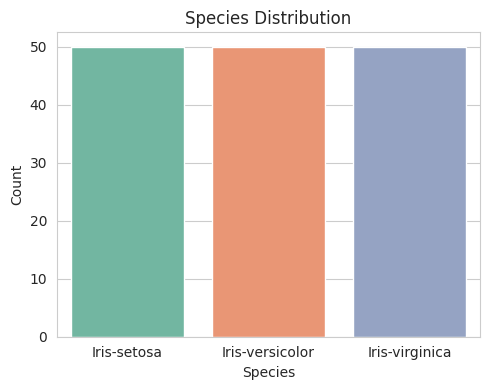

In [7]:
# Distribution of each species
plt.figure(figsize=(5, 4))
sns.countplot(x="Species", data=df, palette="Set2")
plt.title("Species Distribution")
plt.xlabel("Species")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

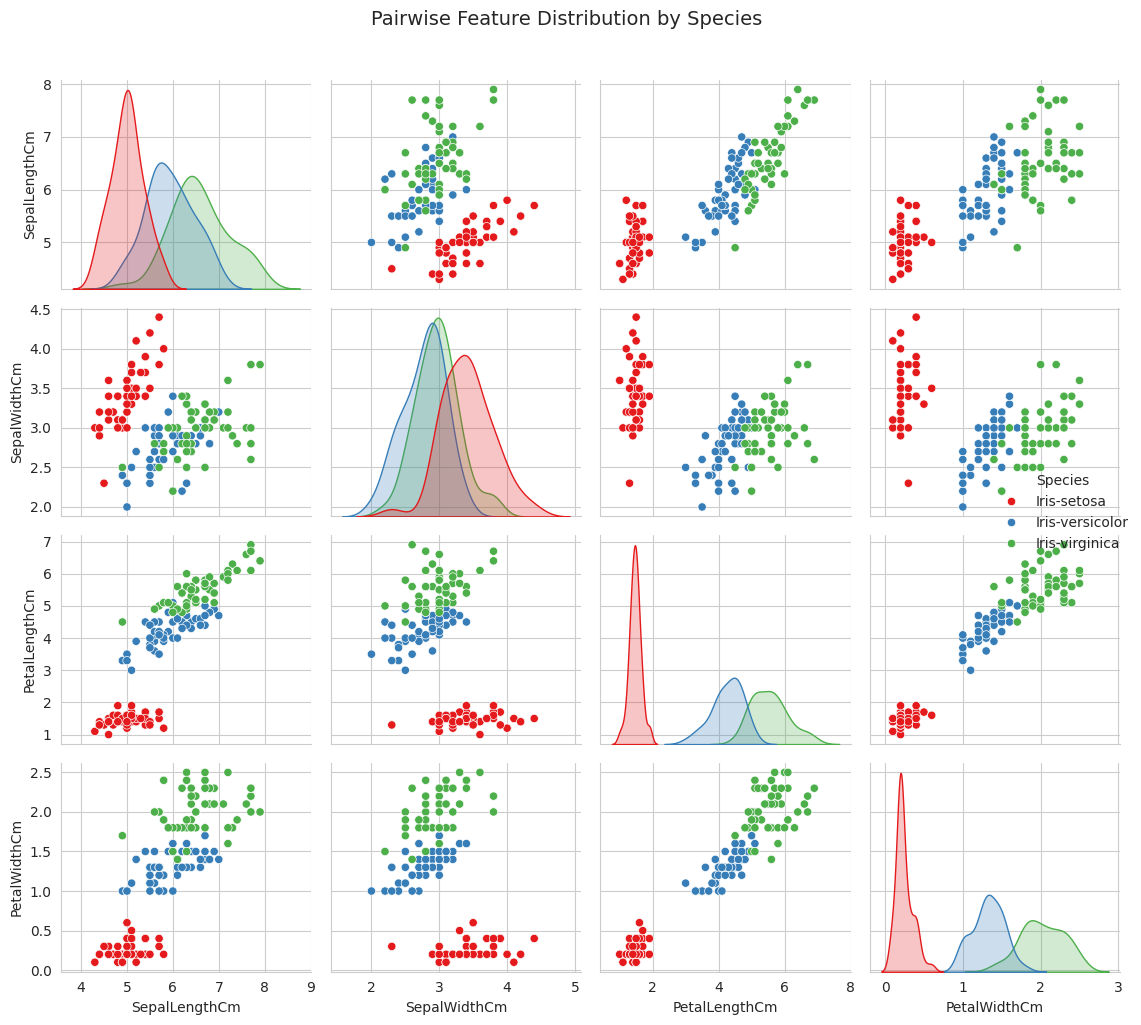

In [8]:
# Pairplot — scatter plots of every feature pair, coloured by species
# This helps visualise how separable the three classes are
sns.pairplot(df.drop("Id", axis=1), hue="Species", palette="Set1", diag_kind="kde")
plt.suptitle("Pairwise Feature Distribution by Species", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

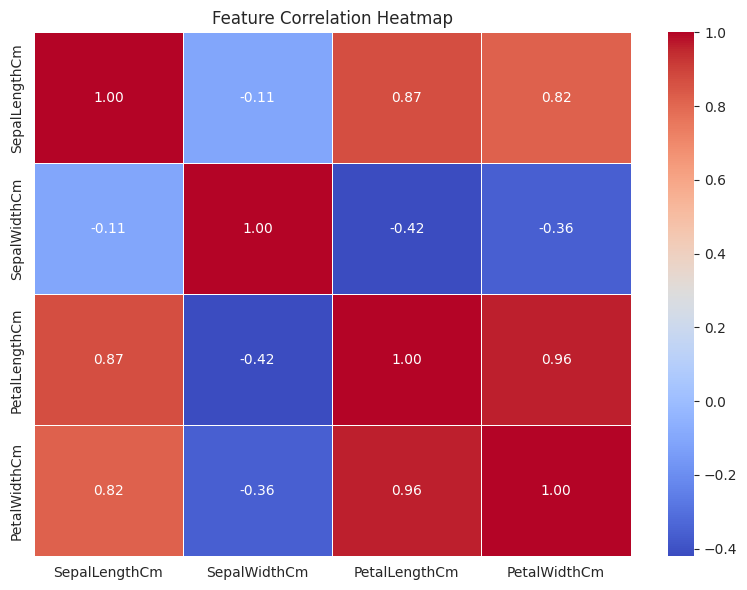

In [9]:
# Correlation heatmap (numeric features only)
plt.figure(figsize=(8, 6))
sns.heatmap(df.drop("Id", axis=1).select_dtypes(include=np.number).corr(),
            annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

## Step 4 — Prepare Features (X) and Target (y)

We drop the `Id` column (not a feature) and the `Species` column (target).  
Since `Species` is text, we encode it to numbers using **LabelEncoder**.

In [10]:
# Encode species names to numbers: setosa=0, versicolor=1, virginica=2
le = LabelEncoder()
df["Species_encoded"] = le.fit_transform(df["Species"])

# X = the 4 measurement columns  |  y = encoded species
X = df[["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = df["Species_encoded"]

print(f"Features shape : {X.shape}")
print(f"Target shape   : {y.shape}")
print(f"Class mapping  : {dict(zip(le.classes_, le.transform(le.classes_)))}")

Features shape : (150, 4)
Target shape   : (150,)
Class mapping  : {'Iris-setosa': np.int64(0), 'Iris-versicolor': np.int64(1), 'Iris-virginica': np.int64(2)}


In [11]:
# Split into training (80%) and testing (20%) sets
# random_state ensures reproducibility — same split every time
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training samples : {X_train.shape[0]}")
print(f"Testing samples  : {X_test.shape[0]}")

Training samples : 120
Testing samples  : 30


In [12]:
# Feature scaling — CRITICAL for KNN!
# KNN uses distance (e.g. Euclidean) to find neighbours.
# If one feature has a much larger range, it dominates the distance calculation.
# StandardScaler makes every feature have mean=0 and std=1.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)   # fit on train, transform train
X_test = scaler.transform(X_test)         # only transform test (no fitting!)

print("Feature scaling done ✅")

Feature scaling done ✅


## Step 5 — Find the Best K Value

The choice of **K** (number of neighbours) greatly affects performance:
- **K too small** → model is sensitive to noise (overfitting)
- **K too large** → model is too general (underfitting)

We try K = 1 to 20 and pick the one with the highest test accuracy.

In [13]:
# Try K from 1 to 20 and record the accuracy for each
k_range = range(1, 21)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    score = knn.score(X_test, y_test)       # accuracy on test set
    k_scores.append(score)
    print(f"K = {k:2d}  →  Accuracy = {score:.4f}")

# Find the K with the highest accuracy
best_k = list(k_range)[np.argmax(k_scores)]
print(f"\n🏆 Best K = {best_k} with Accuracy = {max(k_scores):.4f}")

K =  1  →  Accuracy = 1.0000
K =  2  →  Accuracy = 1.0000
K =  3  →  Accuracy = 1.0000
K =  4  →  Accuracy = 1.0000
K =  5  →  Accuracy = 1.0000
K =  6  →  Accuracy = 1.0000
K =  7  →  Accuracy = 1.0000
K =  8  →  Accuracy = 1.0000
K =  9  →  Accuracy = 1.0000
K = 10  →  Accuracy = 1.0000
K = 11  →  Accuracy = 1.0000
K = 12  →  Accuracy = 1.0000
K = 13  →  Accuracy = 1.0000
K = 14  →  Accuracy = 1.0000
K = 15  →  Accuracy = 1.0000
K = 16  →  Accuracy = 1.0000
K = 17  →  Accuracy = 1.0000
K = 18  →  Accuracy = 1.0000
K = 19  →  Accuracy = 1.0000
K = 20  →  Accuracy = 1.0000

🏆 Best K = 1 with Accuracy = 1.0000


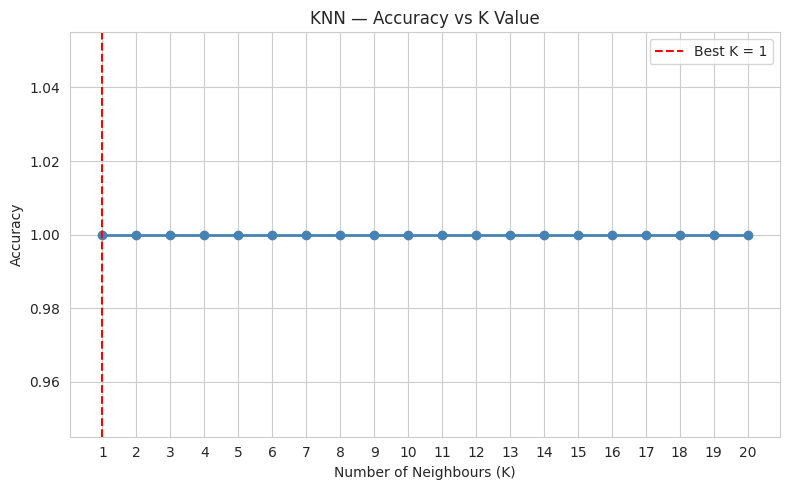

In [14]:
# Plot Accuracy vs K — the "elbow" helps us choose the best K
plt.figure(figsize=(8, 5))
plt.plot(k_range, k_scores, marker="o", linewidth=2, color="steelblue")
plt.axvline(x=best_k, color="red", linestyle="--", label=f"Best K = {best_k}")
plt.xlabel("Number of Neighbours (K)")
plt.ylabel("Accuracy")
plt.title("KNN — Accuracy vs K Value")
plt.xticks(list(k_range))
plt.legend()
plt.tight_layout()
plt.show()

## Step 6 — Train KNN with the Best K and Evaluate

In [15]:
# Train the final KNN model with the best K value
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train, y_train)

# Predict on the test set
y_pred = knn_model.predict(X_test)

print(f"KNN model trained with K = {best_k} ✅")

KNN model trained with K = 1 ✅


In [16]:
# Detailed classification report — precision, recall, f1 per class
print("=" * 55)
print("   KNN — Classification Report")
print("=" * 55)
print(classification_report(y_test, y_pred, target_names=le.classes_))

   KNN — Classification Report
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00         9
 Iris-virginica       1.00      1.00      1.00        11

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30



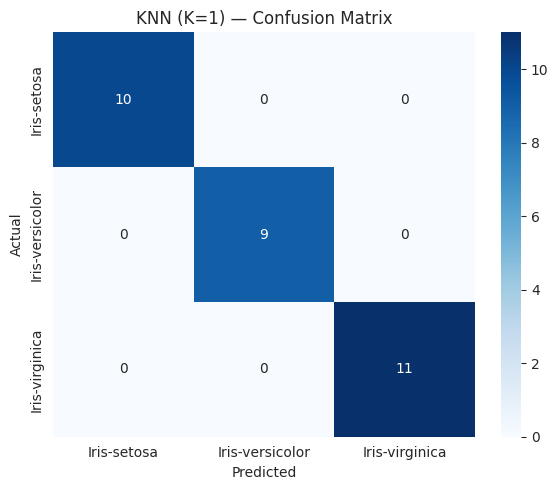

In [17]:
# Confusion Matrix — shows correct vs incorrect predictions per class
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title(f"KNN (K={best_k}) — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

## Step 7 — Performance Metrics Summary

In [18]:
# Calculate overall metrics (weighted average handles multi-class)
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="weighted")
rec  = recall_score(y_test, y_pred, average="weighted")
f1   = f1_score(y_test, y_pred, average="weighted")

print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1 Score  : {f1:.4f}")

Accuracy  : 1.0000
Precision : 1.0000
Recall    : 1.0000
F1 Score  : 1.0000


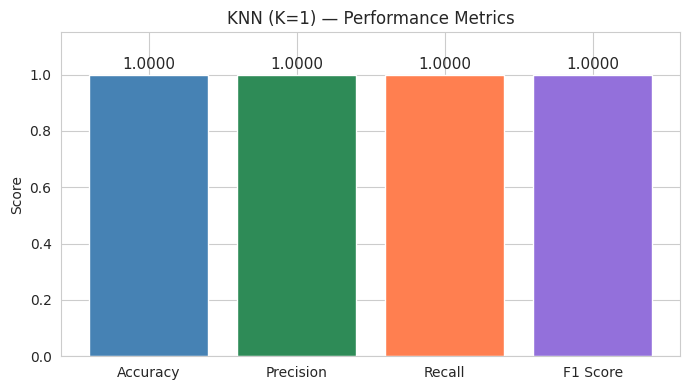

In [19]:
# Visual bar chart of the metrics
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
scores  = [acc, prec, rec, f1]

plt.figure(figsize=(7, 4))
bars = plt.bar(metrics, scores, color=["steelblue", "seagreen", "coral", "mediumpurple"])
plt.ylim(0, 1.15)
# Add value labels on top of each bar
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f"{score:.4f}", ha="center", fontsize=11)
plt.title(f"KNN (K={best_k}) — Performance Metrics")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

## Step 8 — Visualise Decision Boundaries (2D)

To see *how* KNN separates classes, we plot decision boundaries using only the two most important features: **PetalLengthCm** and **PetalWidthCm**.

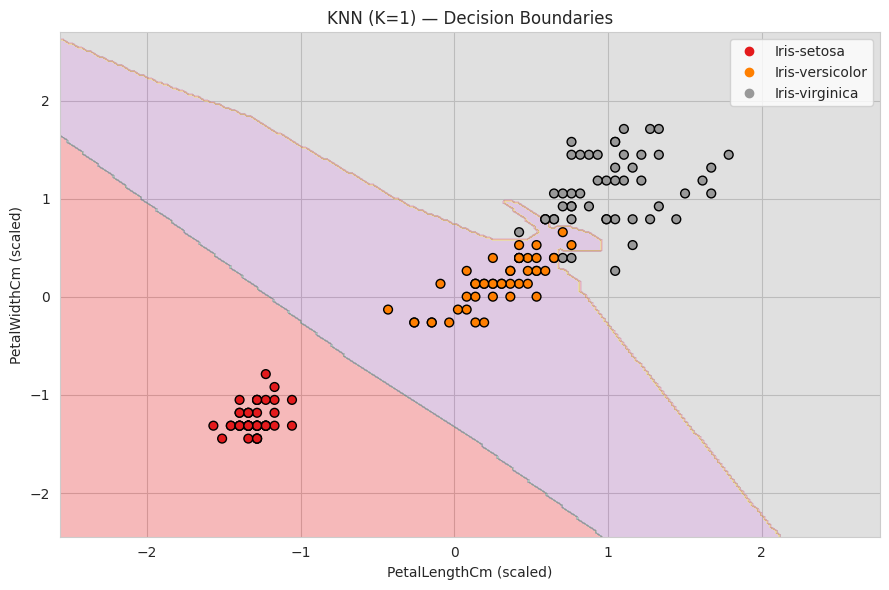

In [20]:
# Use only 2 features so we can plot on a 2D plane
X_2d = df[["PetalLengthCm", "PetalWidthCm"]].values
y_2d = df["Species_encoded"].values

# Scale these 2 features
scaler_2d = StandardScaler()
X_2d = scaler_2d.fit_transform(X_2d)

# Train a KNN on these 2 features
knn_2d = KNeighborsClassifier(n_neighbors=best_k)
knn_2d.fit(X_2d, y_2d)

# Create a mesh grid covering the feature space
h = 0.02  # step size
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predict class for every point in the mesh
Z = knn_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundaries + actual data points
plt.figure(figsize=(9, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap="Set1")
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d, cmap="Set1",
                      edgecolors="k", s=40)
plt.xlabel("PetalLengthCm (scaled)")
plt.ylabel("PetalWidthCm (scaled)")
plt.title(f"KNN (K={best_k}) — Decision Boundaries")
plt.legend(handles=scatter.legend_elements()[0], labels=list(le.classes_))
plt.tight_layout()
plt.show()

## Conclusion

| Aspect | Detail |
|---|---|
| **Algorithm** | K-Nearest Neighbors (KNN) |
| **Dataset** | Iris — 150 samples, 3 classes, 4 features |
| **Best K** | Found via accuracy curve over K = 1–20 |
| **Scaling** | StandardScaler (essential — KNN is distance-based) |
| **Evaluation** | Accuracy, Precision, Recall, F1, Confusion Matrix |

**Key takeaways:**
- KNN is a simple, non-parametric algorithm — it memorises the training data instead of learning weights.
- Feature scaling is **critical** because KNN relies on distance; unscaled features with larger ranges would dominate.
- Choosing the right K avoids overfitting (K too small) and underfitting (K too large).